# EECS 531: Computer Vision Assignment 4
**David Fan**

4/13/18

# Exercise 1

In this notebook we will be writing a function to compute and display an optical flow field by estimating motion with correlation. The function will find the location of maximum response by convolving a small $n\times n$ image patch centered on pixel $(x,y)$ from one frame over a local region of the next frame. This method is rather trivial compared to the method explored in Exercise 2.

## Imports and Preprocessing

In [46]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from skimage import io

In [47]:
def plotflow(I, X, Y, U, V, scale=1, threshold=-1):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    if threshold > 0:
        mask = np.abs(U + 1j*V) > threshold
        X = X[mask]
        Y = Y[mask]
        U = U[mask]
        V = V[mask]
        
    ax.imshow(I, cmap='gray')
    ax.quiver(X, Y, U*scale, V*scale, color='red', angles='xy', scale_units='xy', scale=1)
    ax.set_aspect('equal')
    plt.show()

seq1 = {'I1': io.imread('data/image/seq1/frame1.png', as_grey=True), 
        'I2': io.imread('data/image/seq1/frame3.png', as_grey=True),
        'U' : np.loadtxt('data/flow/seq1/flow3.u', dtype='double', delimiter=','),
        'V' : np.loadtxt('data/flow/seq1/flow3.v', dtype='double', delimiter=',')}

rubic = {'I1':io.imread('data/rubic/rubic.0.png', as_grey=True), 
         'I2':io.imread('data/rubic/rubic.5.png', as_grey=True)}

sphere= {'I1': io.imread('data/sphere/sphere.1.png', as_grey=True), 
         'I2': io.imread('data/sphere/sphere.3.png', as_grey=True)}


I = np.random.rand(128, 128)
synth = {'I1': I[0:100, 0:100], 
         'I2': I[2:102, 2:102]}

The above preprocessing steps were taken from the demo. The function just allows us to plot optical flow fields on top of images and the rest of it maps frames of image data to a dictionary for testing.

## Estimate Moving Vector for a Patch

In [48]:
def estimate_mv_xy(I1, I2, x, y, n, u0, v0):
    h, w = I1.shape
    x = int(x)
    y = int(y)
    n2 = int(np.floor(n/2))
    
    i11 = (y-n2)   > 0 and y-n2 or 0
    i12 = (y+n2+1) < h and y+n2+1 or h
    j11 = (x-n2)   > 0 and x-n2 or 0
    j12 = (x+n2+1) < w and x+n2+1 or w 
    patch = I1[i11:i12, j11:j12]
    
    
    i21 = y-n2-v0   > 0 and y-n2-v0 or 0
    i22 = y+n2+1+v0 < h and y+n2+1+v0 or h
    j21 = x-n2-u0   > 0 and x-n2-u0 or 0
    j22 = x+n2+1+u0 < w and x+n2+1+u0 or w 
    region = I2[i21:i22, j21:j22]
    
    
    response = convolve2d(region, patch, 'valid')
    i, j = np.unravel_index(response.argmax(), response.shape)
    
    
    u = j21-j11+j
    v = i21-i11+i
    return (u, v)

The function above extracts the patch of interest from image 1 and extracts the search region from image 2 and computes the convolution of the two. It then calculates the motion vectors from the maximum response of the correlation.

## Estimate Optical Flow Field for an Entire Image

In [49]:
def estimate_mv(I1, I2, gridX, gridY, n, u0, v0):
    H, W = gridX.shape
    U = np.zeros((H, W))
    V = np.zeros((H, W))
    
    for i in range(0, H):
        for j in range(0, W):
            u, v =  estimate_mv_xy(I1, I2,gridX[i, j], gridY[i, j], n, u0, v0)
            U[i, j] = u
            V[i, j] = v
            
    return (U, V)

The above function uses the earlier estimate moving vector from patch function to compute the moving vectors for all patches of the image.

## Compute Optical Flow Field for all Test Images

The algorithm above is quite simple. Let's see how it performs on our test image data. The parameters gridsz and wsz in the test function below specify how far apart the motion vectors should be spaced and how large should each patch be.

For testing we are comparing the first frame of sequence 1 to the third frame of sequence 1, the first frame of "rubic" to the sixth frame of "rubic" and the second frame of "sphere" to the fourth frame of "sphere". Let's first show those frames side by side to give a visual reference of the motion we wish to estimate.

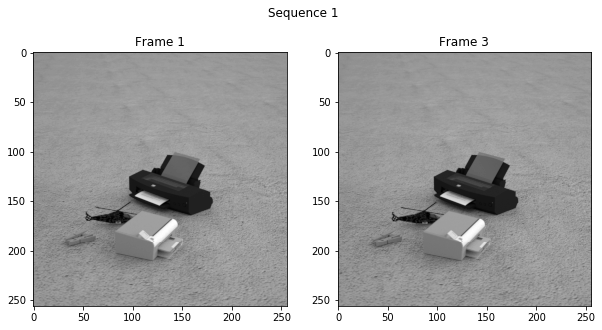

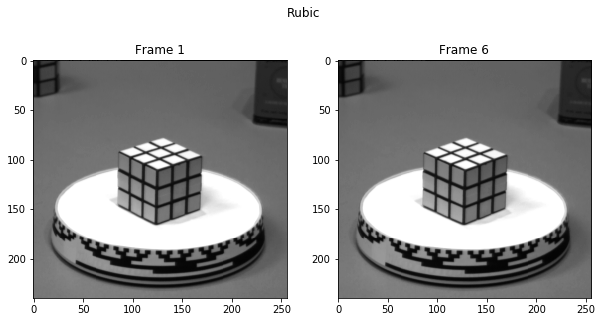

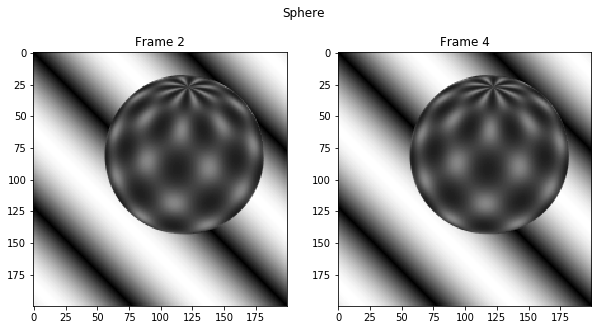

In [50]:
def compare_frames(seq, name, I1_title, I2_title):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle(name)
    axes[0].set_title(I1_title)
    axes[0].imshow(seq["I1"], cmap='gray')
    axes[1].set_title(I2_title)
    axes[1].imshow(seq["I2"], cmap='gray')
    
compare_frames(seq1, "Sequence 1", "Frame 1", "Frame 3")
compare_frames(rubic, "Rubic", "Frame 1", "Frame 6")
compare_frames(sphere, "Sphere", "Frame 2", "Frame 4")

Now let's compute and display the flow fields.

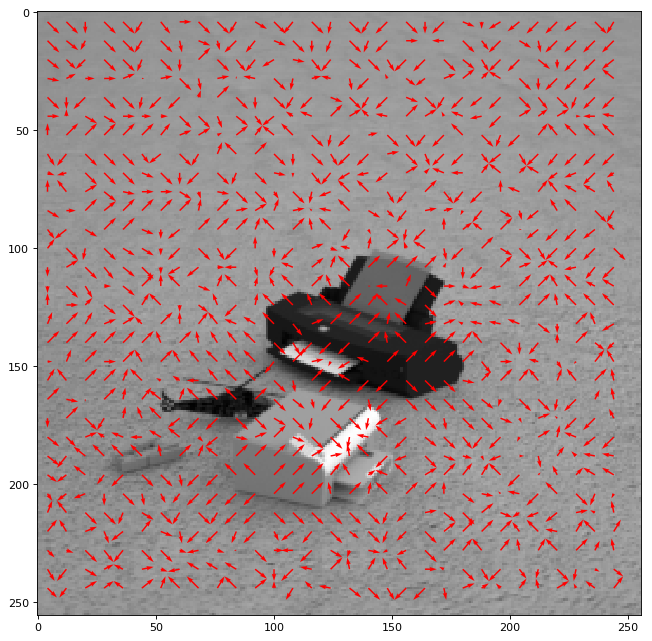

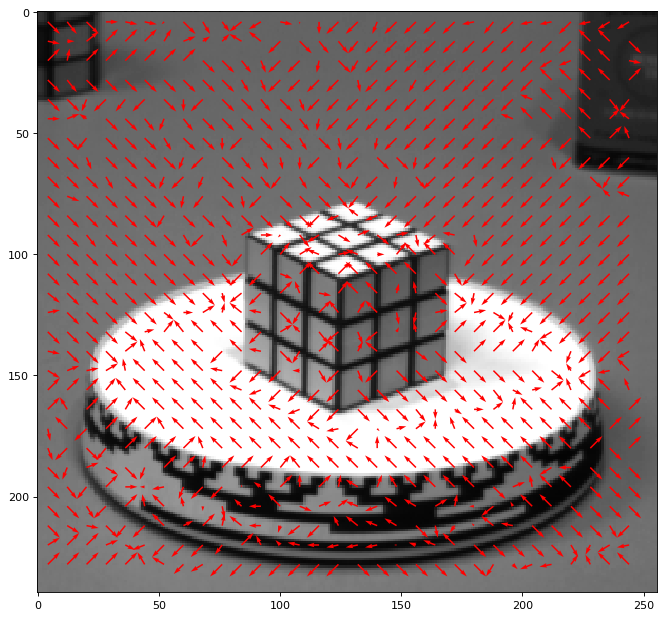

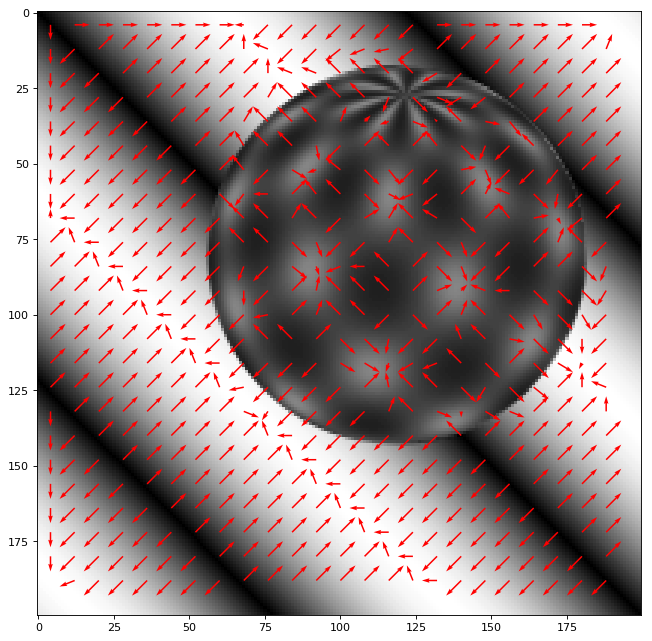

In [51]:
def test_estimate_mv(seq):
    H, W = seq['I1'].shape
    gridsz = 8
    wsz  = 11
    u0 = 5
    v0 = 5
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2);
    gridX, gridY = np.meshgrid(x,y);
    U, V = estimate_mv(seq["I1"], seq["I2"], gridX, gridY, wsz, u0, v0)
    plotflow(seq["I1"], gridX, gridY, U, V, 1, 0.3)

test_estimate_mv(seq1)
test_estimate_mv(rubic)
test_estimate_mv(sphere)